**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
#data_dir_train = pathlib.Path("path_to_train_directory")
#data_dir_test = pathlib.Path('path_to_test_directory')

data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
image_size = (180, 180)

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=image_size,
                                                             batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Data Visualization
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

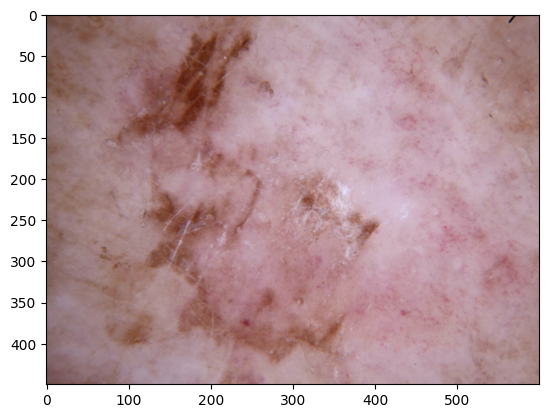

In [ ]:
### Visualize one instance of all the class present in the dataset.
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

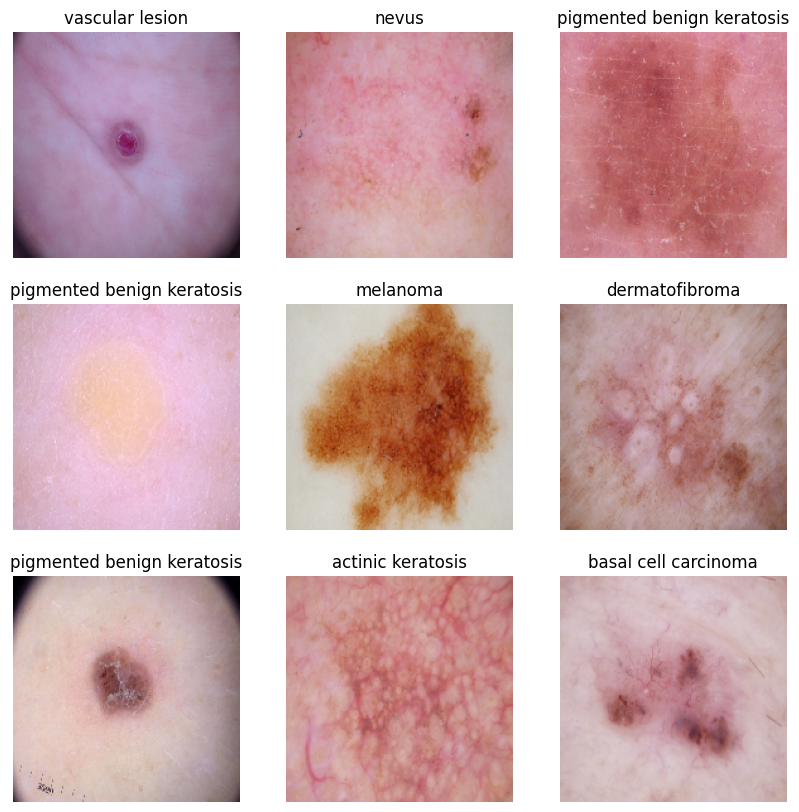

In [ ]:
# Displaying a 3x3 grid of sample images from the training dataset with their corresponding class labels
# This helps visualize one instance of each class present in the dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# Building a CNN model with two convolutional layers followed by max pooling and a dense output layer for classification
# The model is designed to scale images and classify them into 9 different categories using softmax activation

model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 0.2037 - loss: 8.1261 - val_accuracy: 0.2931 - val_loss: 2.0288
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.3348 - loss: 1.8438 - val_accuracy: 0.3423 - val_loss: 1.8175
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.4376 - loss: 1.5657 - val_accuracy: 0.5280 - val_loss: 1.4418
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4901 - loss: 1.4631 - val_accuracy: 0.5280 - val_loss: 1.4317
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5042 - loss: 1.3765 - val_accuracy: 0.4609 - val_loss: 1.5677
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5672 - loss: 1.2322 - val_accuracy: 0.5101 - val_loss: 1.5494
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5801 - loss: 1.1820 - val_accuracy: 0.5145 - val_loss: 1.5012
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6516 - loss: 1.0285 - val_accuracy: 0.4944 -

### Visualizing training results

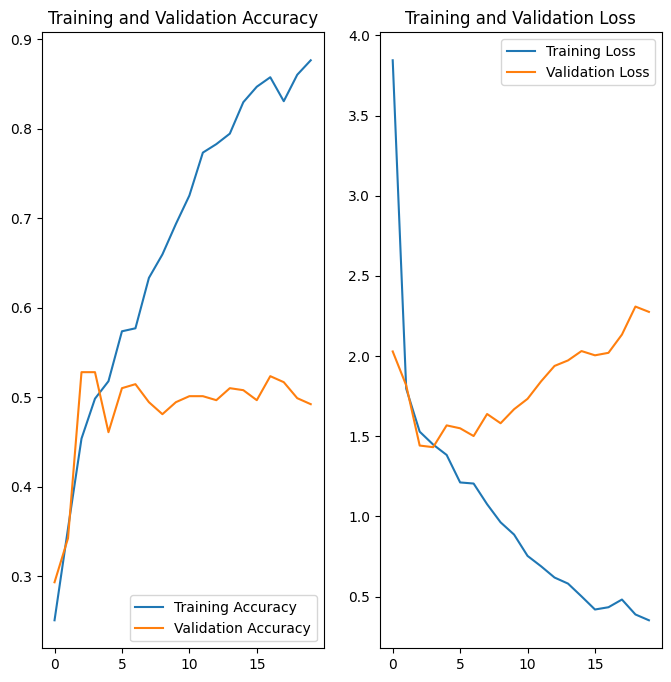

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here



*   Training accuracy is rising steadily, while validation accuracy stays between 45% and 55%.

*   As the number of epochs grows, both training and validation losses show an upward trend.

*   This suggests that the model may be overfitting, given the notable gap between training and validation accuracy.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
image_height = 180
image_width = 180
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(image_height,image_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

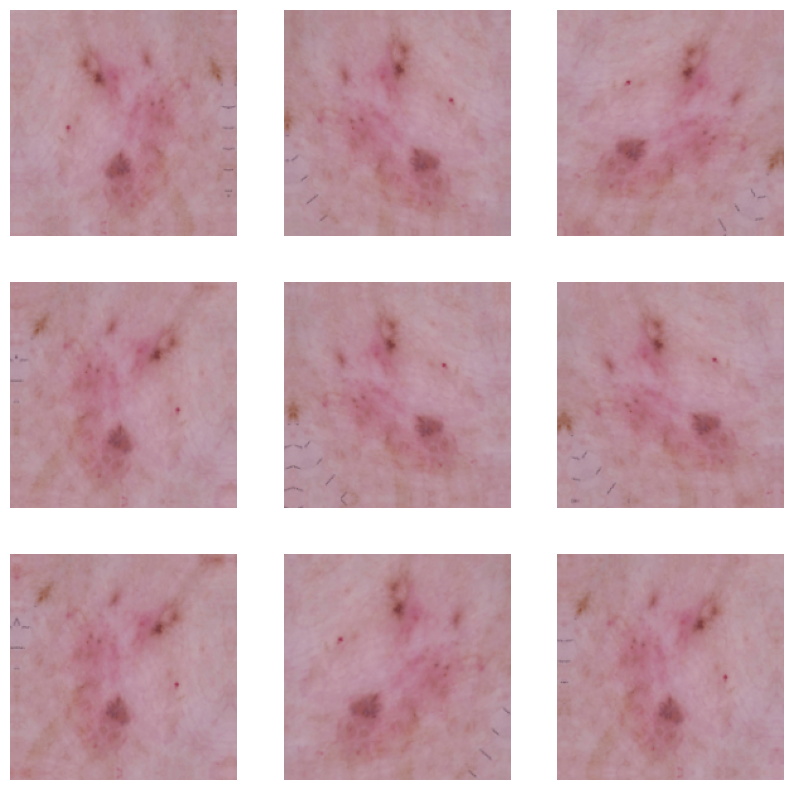

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Defining the CNN model with data augmentation and convolutional layers for feature extraction

model = models.Sequential()

# Scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))

# Data augmentation layer (assumed to be predefined)
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter, relu activation with max pooling and dropout
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

# Convolution layer with 128 features, 3x3 filter, relu activation with max pooling and dropout
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))



### Compiling the model

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.1487 - loss: 12.0960 - val_accuracy: 0.2058 - val_loss: 2.0448
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.2135 - loss: 2.0499 - val_accuracy: 0.2438 - val_loss: 2.0600
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.2481 - loss: 2.0003 - val_accuracy: 0.2707 - val_loss: 1.9795
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.3175 - loss: 1.8189 - val_accuracy: 0.3758 - val_loss: 1.7406
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.4023 - loss: 1.6358 - val_accuracy: 0.4273 - val_loss: 1.6025
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.4691 - loss: 1.5050 - val_accuracy: 0.5078 - val_loss: 1.5349
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.4984 - loss: 1.4367 - val_accuracy: 0.4966 - val_loss: 1.5059
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.5122 - loss: 1.3711 - val_accura

### Visualizing the results

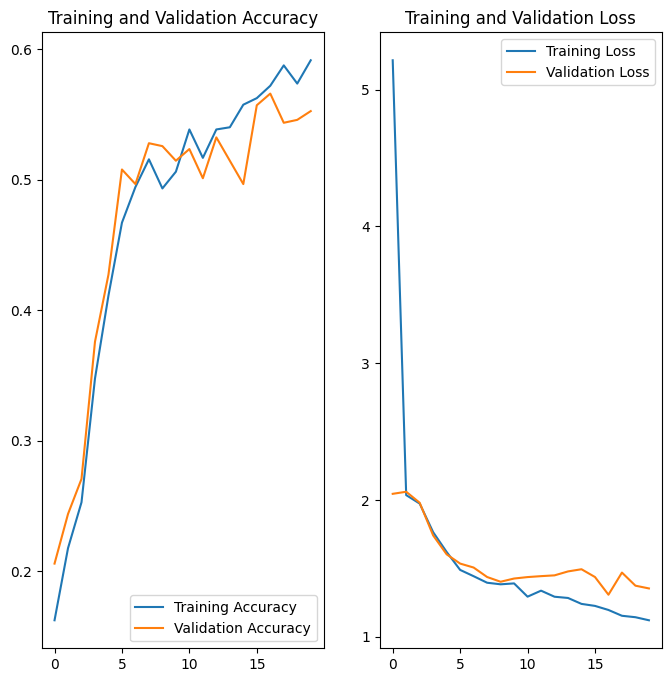

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings:**
*    From the model, there is no substancial difference between training accuracy and validation accuracy and difference which is slightly noticeable
*   As the no of epochs increases, we afre observing the gap between training loss and validation loss, which could be sign of overfitting





#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# Defining the CNN model with data augmentation and convolutional layers for feature extraction

model = models.Sequential()

# Scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))

# Data augmentation layer (assumed to be predefined)
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter, relu activation with max pooling and dropout
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

# Convolution layer with 128 features, 3x3 filter, relu activation with max pooling and dropout
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

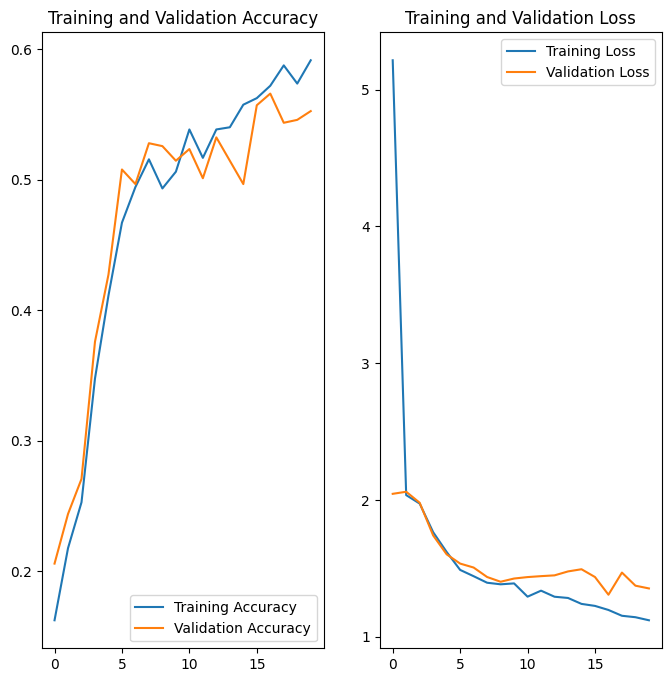

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,462
1,seborrheic keratosis,77
2,squamous cell carcinoma,181
3,vascular lesion,139
4,basal cell carcinoma,376
5,melanoma,438
6,actinic keratosis,114
7,dermatofibroma,95
8,nevus,357


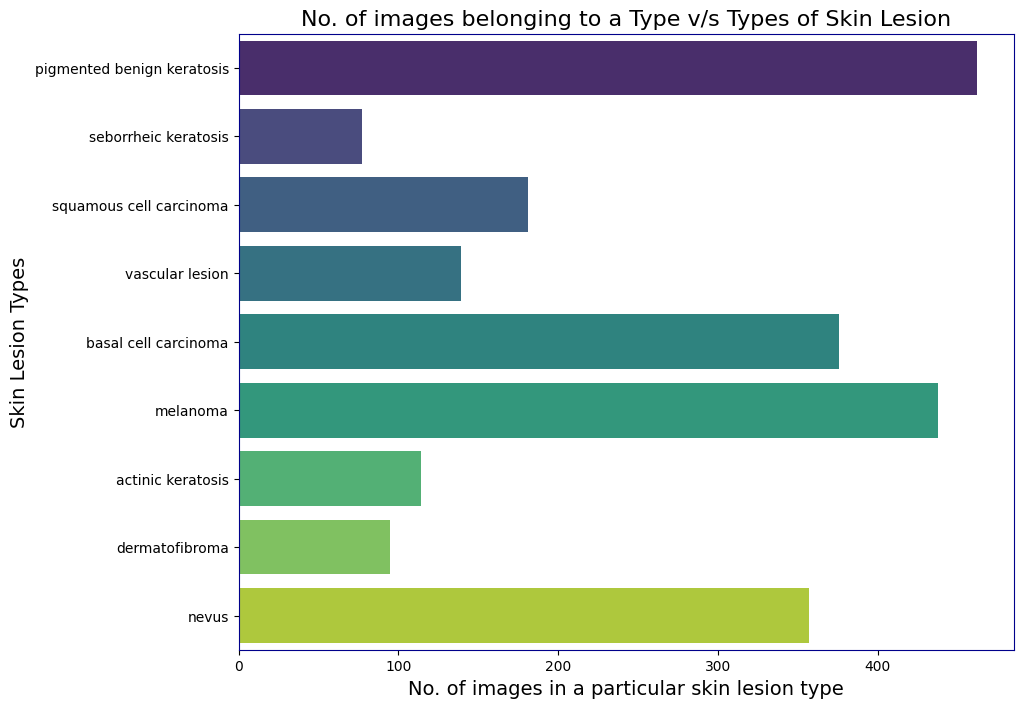

In [ ]:
#Visualize the Number of image in each class.

import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom color palette (optional)
palette = sns.color_palette("viridis", len(df["Class"].unique()))

# Create the bar plot with color palette
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, palette=palette)

# Adding color bar lines (if needed)
plt.gca().spines['left'].set_color('darkblue')
plt.gca().spines['right'].set_color('darkblue')
plt.gca().spines['top'].set_color('darkblue')
plt.gca().spines['bottom'].set_color('darkblue')

plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
 *   seborrheic keratosis has the least number of samples 77

#### - Which classes dominate the data in terms proportionate number of samples?
*   pigmented benign keratosis dominate the data in number of samples 462



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CEFF706D720>: 100%|██████████| 500/500 [00:54<00:00,  9.09 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CEFF0734D30>: 100%|██████████| 500/500 [00:40<00:00, 12.44 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CEFF1768F70>: 100%|██████████| 500/500 [00:46<00:00, 10.83 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7CEFF16652D0>: 100%|██████████| 500/500 [00:40<00:00, 12.48 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7CF074404970>: 100%|██████████| 500/500 [00:45<00:00, 11.07 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7CF07461C940>: 100%|██████████| 500/500 [00:41<00:00, 11.93 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CF0745CECB0>: 100%|██████████| 500/500 [00:41<00:00, 12.10 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CEFF706CA30>: 100%|██████████| 500/500 [00:45<00:00, 11.09 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF07C12BBB0>: 100%|██████████| 500/500 [00:41<00:00, 12.19 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
data_dir_train1 = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train1, '*', '*.jpg'))]


In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train1, '*', '*.jpg'))]


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [ ]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [ ]:
new_df['Label'].value_counts()


,count
Label,
pigmented benign keratosis,928
melanoma,878
basal cell carcinoma,743
nevus,732
squamous cell carcinoma,356
vascular lesion,273
actinic keratosis,235
dermatofibroma,197
seborrheic keratosis,158


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
# CNN Model
model = models.Sequential()

# Scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))

# Data augmentation layer (assumed to be predefined)
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter, relu activation with max pooling and dropout
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

# Convolution layer with 128 features, 3x3 filter, relu activation with max pooling and dropout
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [ ]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.1782 - loss: 10.6341 - val_accuracy: 0.2944 - val_loss: 1.8999
Epoch 2/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.3644 - loss: 1.7999 - val_accuracy: 0.3389 - val_loss: 1.8712
Epoch 3/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.4365 - loss: 1.6201 - val_accuracy: 0.4667 - val_loss: 1.5608
Epoch 4/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.4970 - loss: 1.4427 - val_accuracy: 0.4078 - val_loss: 1.6058
Epoch 5/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.5001 - loss: 1.4128 - val_accuracy: 0.4489 - val_loss: 1.5204
Epoch 6/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.5147 - loss: 1.3648 - val_accuracy: 0.4811 - val_loss: 1.4454
Epoch 7/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.5313 - loss: 1.3149 - val_accuracy: 0.5078 - val_loss: 1.4031
Epoch 8/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.5239 - loss: 

#### **Todo:**  Visualize the model results

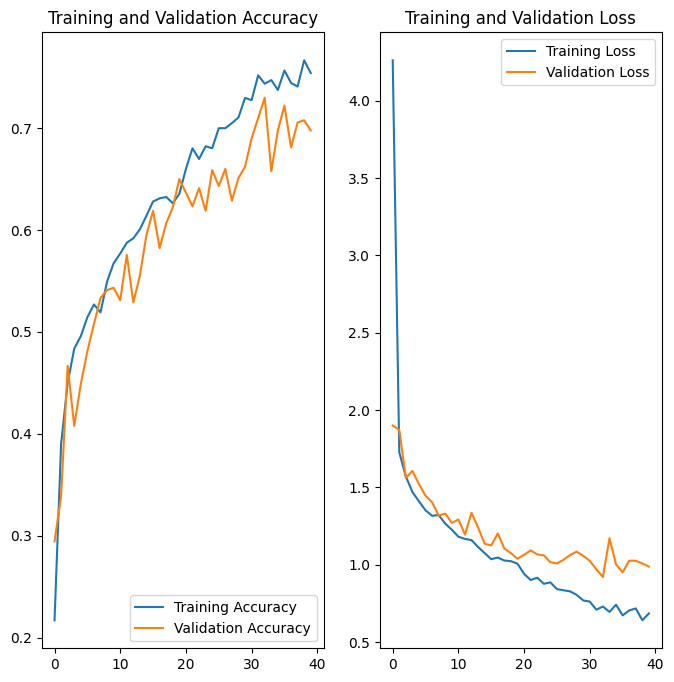

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

*   Class rebalancing eliminated both training and validation loss.
*   Class rebalancing also improved accuracy, reaching approximately 77%.
*   The gap between training loss and validation loss was significantly reduced


**Model Evaluation**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


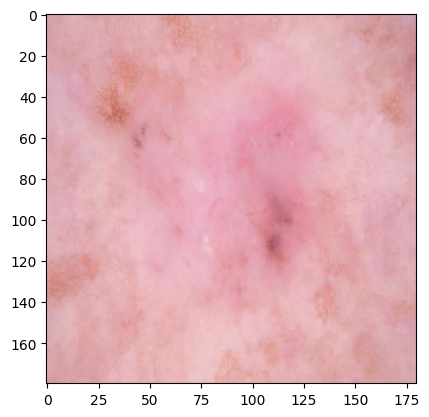

In [ ]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)